<a href="https://colab.research.google.com/github/shahista-shaikh/diabetes-prediction-ml/blob/main/Diabetes_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### import required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
df.isnull().sum().sum()

np.int64(0)

In [ ]:
df.duplicated().sum()

np.int64(0)

### Check for Missing or Invalid Values

In [ ]:
#Some columns may contain zeros that are not valid for medical data.
cols_with_zero = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]

(df[cols_with_zero]==0).sum()

,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11


*I used a hybrid imputation strategy for handling missing values. Since Insulin and SkinThickness have a large number of missing entries, I replaced them with the median to avoid unreliable estimates. For Glucose, BloodPressure, and BMI, I applied KNN imputation so the missing values are filled in based on patterns from similar records.*

In [ ]:
from sklearn.impute import KNNImputer

# Replace 0 with NaN in all medical columns
cols_with_zero = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)

# Median imputation for Insulin and SkinThikness
for col in["Insulin","SkinThickness"]:
    df[col].fillna(df[col].median(), inplace=True)

# KNN imputation for Glucose, BloodPressure, and BMI
knn_cols = ["Glucose","BloodPressure","BMI"]
imputer = KNNImputer(n_neighbors=5)

df[knn_cols] = imputer.fit_transform(df[knn_cols])

print(df.isnull().sum())



Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


### Outcome Distribution

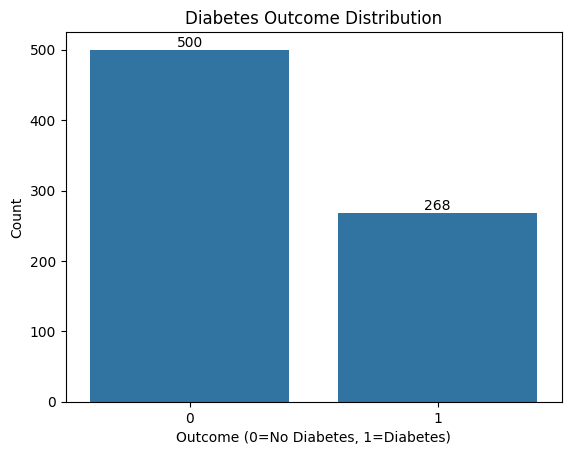

In [ ]:
ax=sns.countplot(x="Outcome",data=df)
ax.bar_label(ax.containers[0])
plt.title("Diabetes Outcome Distribution")
plt.xlabel("Outcome (0=No Diabetes, 1=Diabetes)")
plt.ylabel("Count")
plt.show()

### Histogram with KDE lines for all features

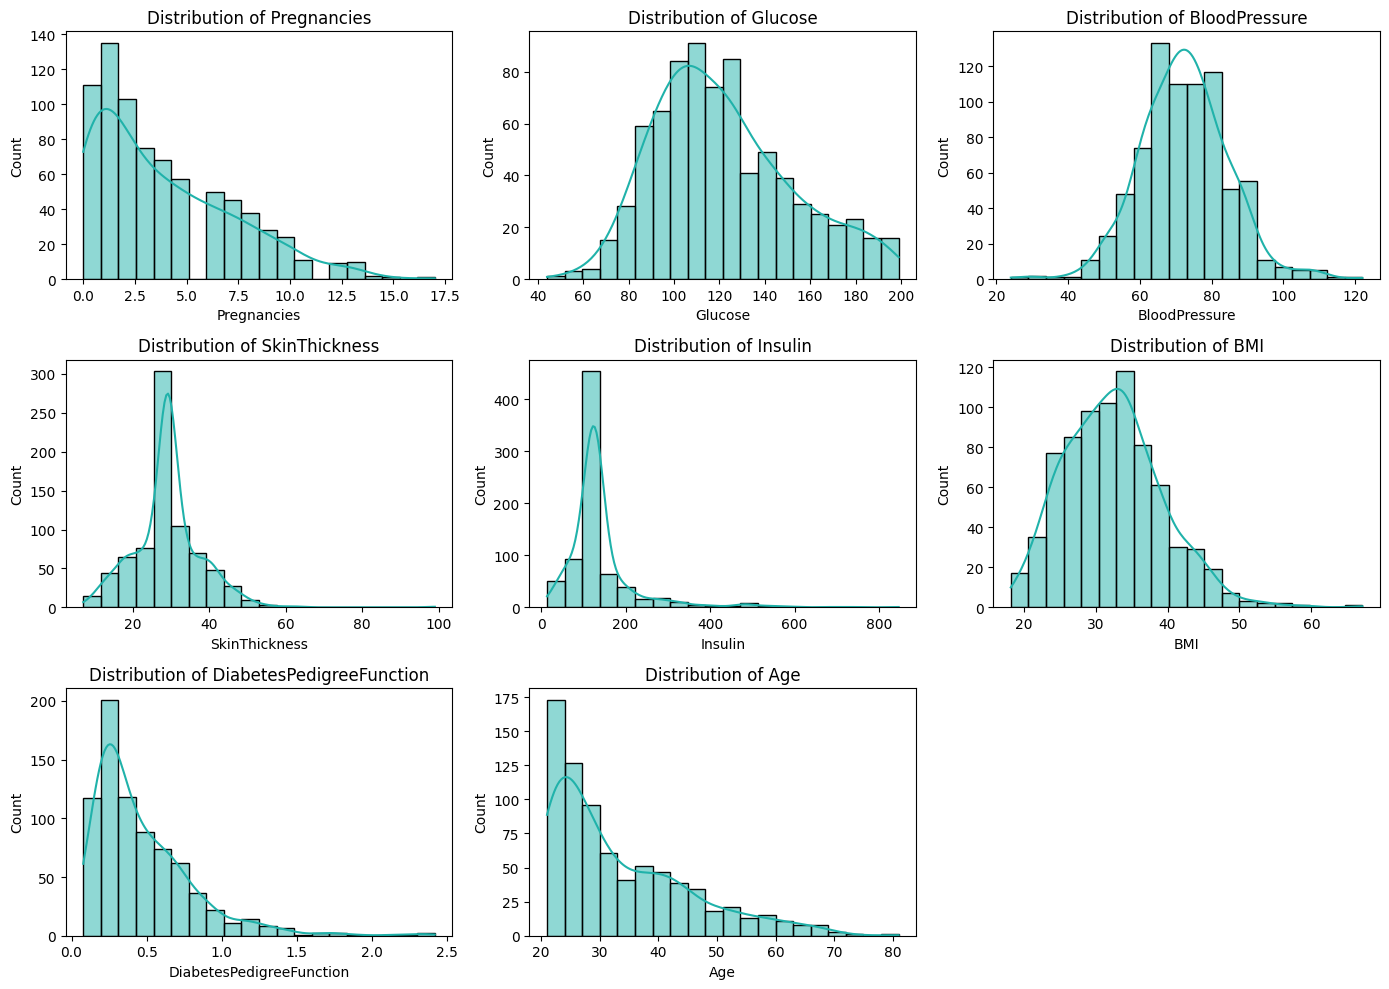

In [ ]:
#exclude target column
df_features=df.drop("Outcome",axis=1)
plt.figure(figsize=(14,10))

for i,col in enumerate(df_features.columns,1):
    plt.subplot(3,3,i)
    sns.histplot(df[col], kde=True, bins=20, color="lightseagreen", edgecolor="black")
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

*In this dataset, I noticed that many features have right-skewed distributions, such as Insulin, Pregnancies, DiabetesPedigreeFunction, and Age, where a few extreme cases push the values higher. Glucose and BMI are more balanced but still lean toward the higher side, while BloodPressure and SkinThickness look closer to a normal distribution. These patterns, along with the outliers, are important to consider before building predictive models.*

### Boxplots (spot outliers clearly)

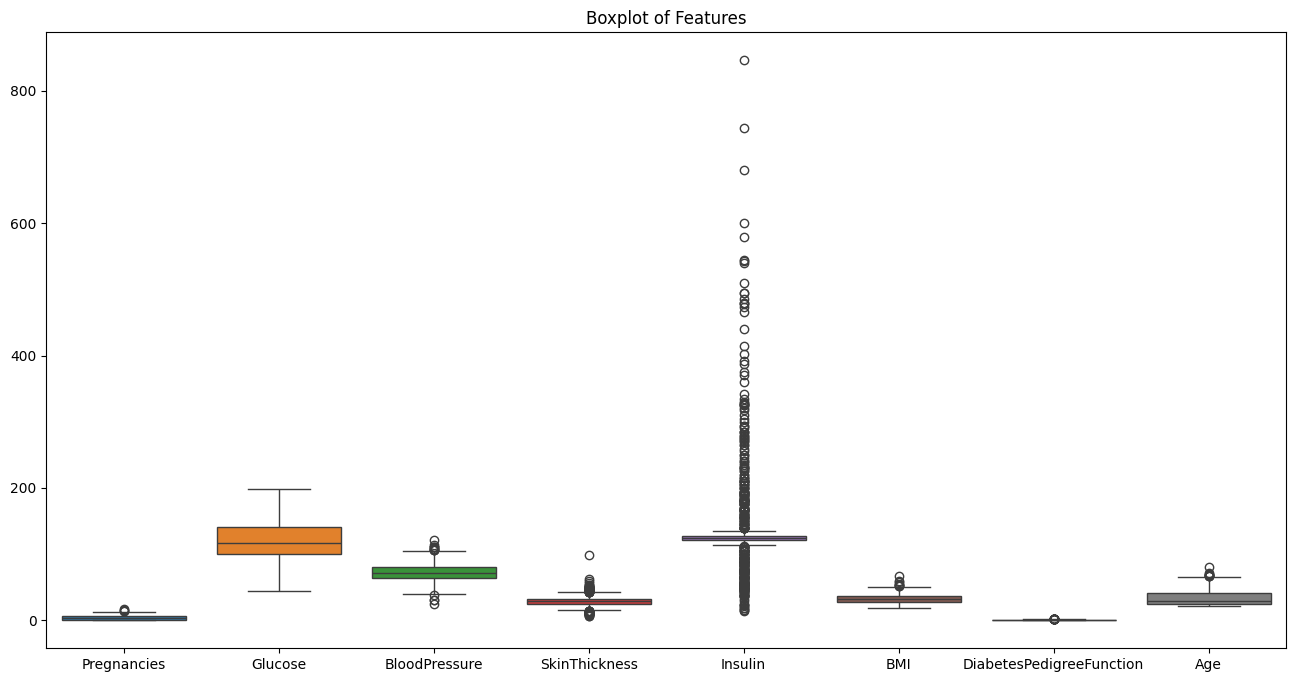

In [ ]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df.drop("Outcome",axis=1),orient="v")
plt.title("Boxplot of Features")
plt.show()


*   *Pregnancies, Age, BMI, and BloodPressure show moderate outliers but remain within a reasonable range.*

*   *Glucose has some variation and a few outliers, but most values are clustered between 90–150.*

*   *SkinThickness is fairly concentrated, with some extreme points above 60.*

*   *Insulin stands out with a very large number of extreme outliers, reaching beyond 800, which makes its distribution highly skewed.*

*   *DiabetesPedigreeFunction has smaller values with fewer noticeable outliers.*

### Violin Plots by Outcome (distribution + diabetes comparison)

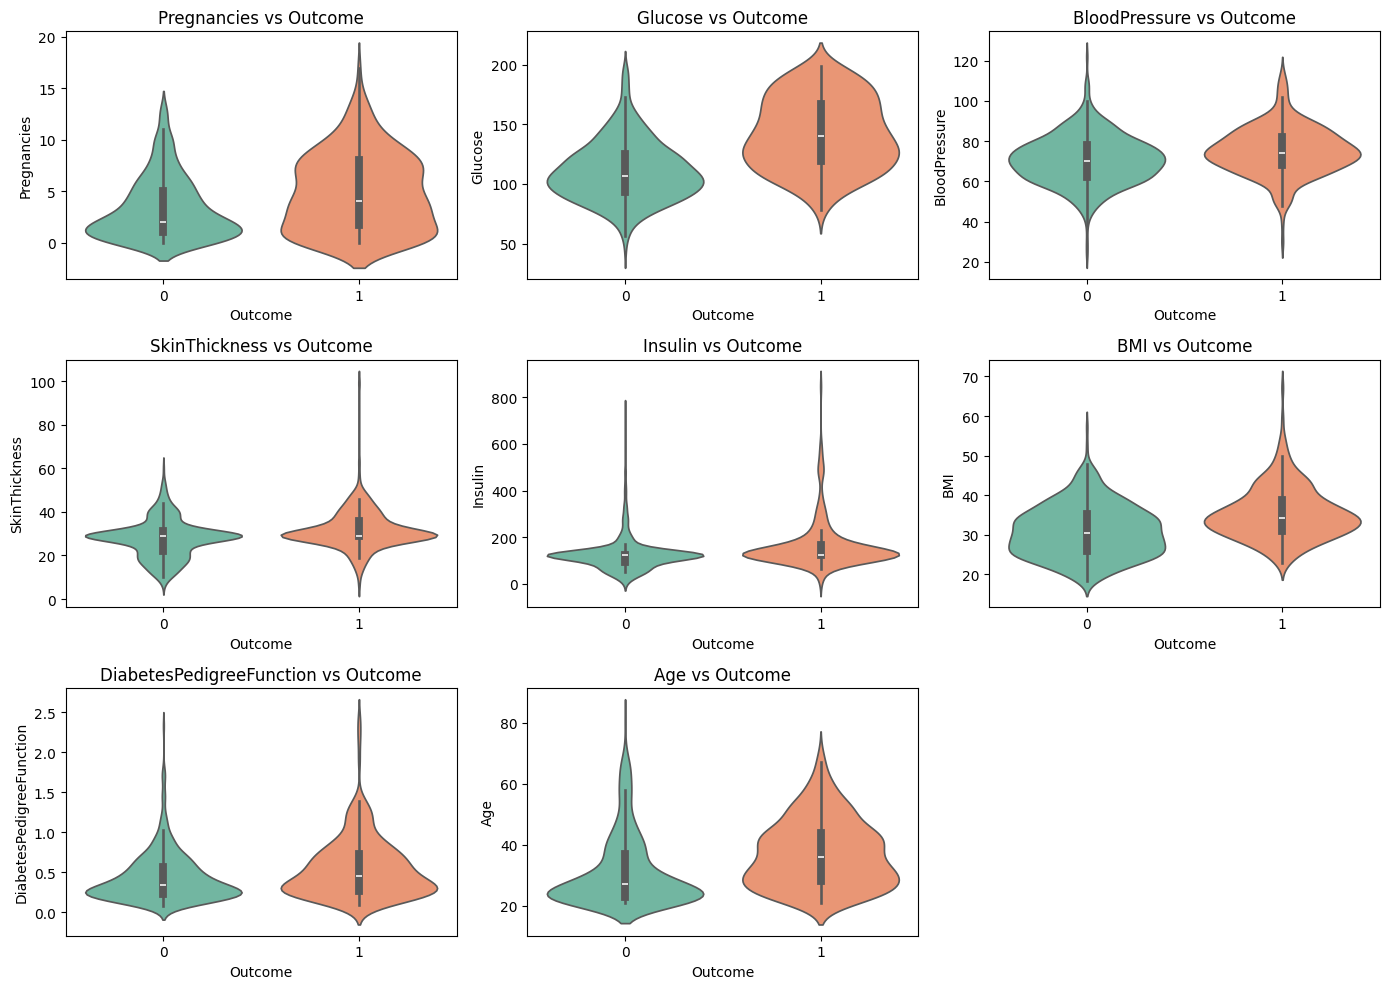

In [ ]:
plt.figure(figsize=(14,10))
for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(3,3,i)
    sns.violinplot(x="Outcome", y=col, data=df, palette="Set2")
    plt.title(f"{col} vs Outcome")
plt.tight_layout()
plt.show()

* *Glucose and BMI show clear separation between the two groups: higher glucose and BMI levels are strongly linked with diabetic outcomes.*

*   *Pregnancies also trend higher in diabetic cases, though with overlapping ranges.*

*   *BloodPressure and SkinThickness show mild differences, but the overlap suggests they may not be strong independent predictors.*

*  *Insulin shows high variability with extreme outliers in both groups, making its predictive power less clear without transformation.*



### Pairplot (relationships between features)

<Figure size 400x400 with 0 Axes>

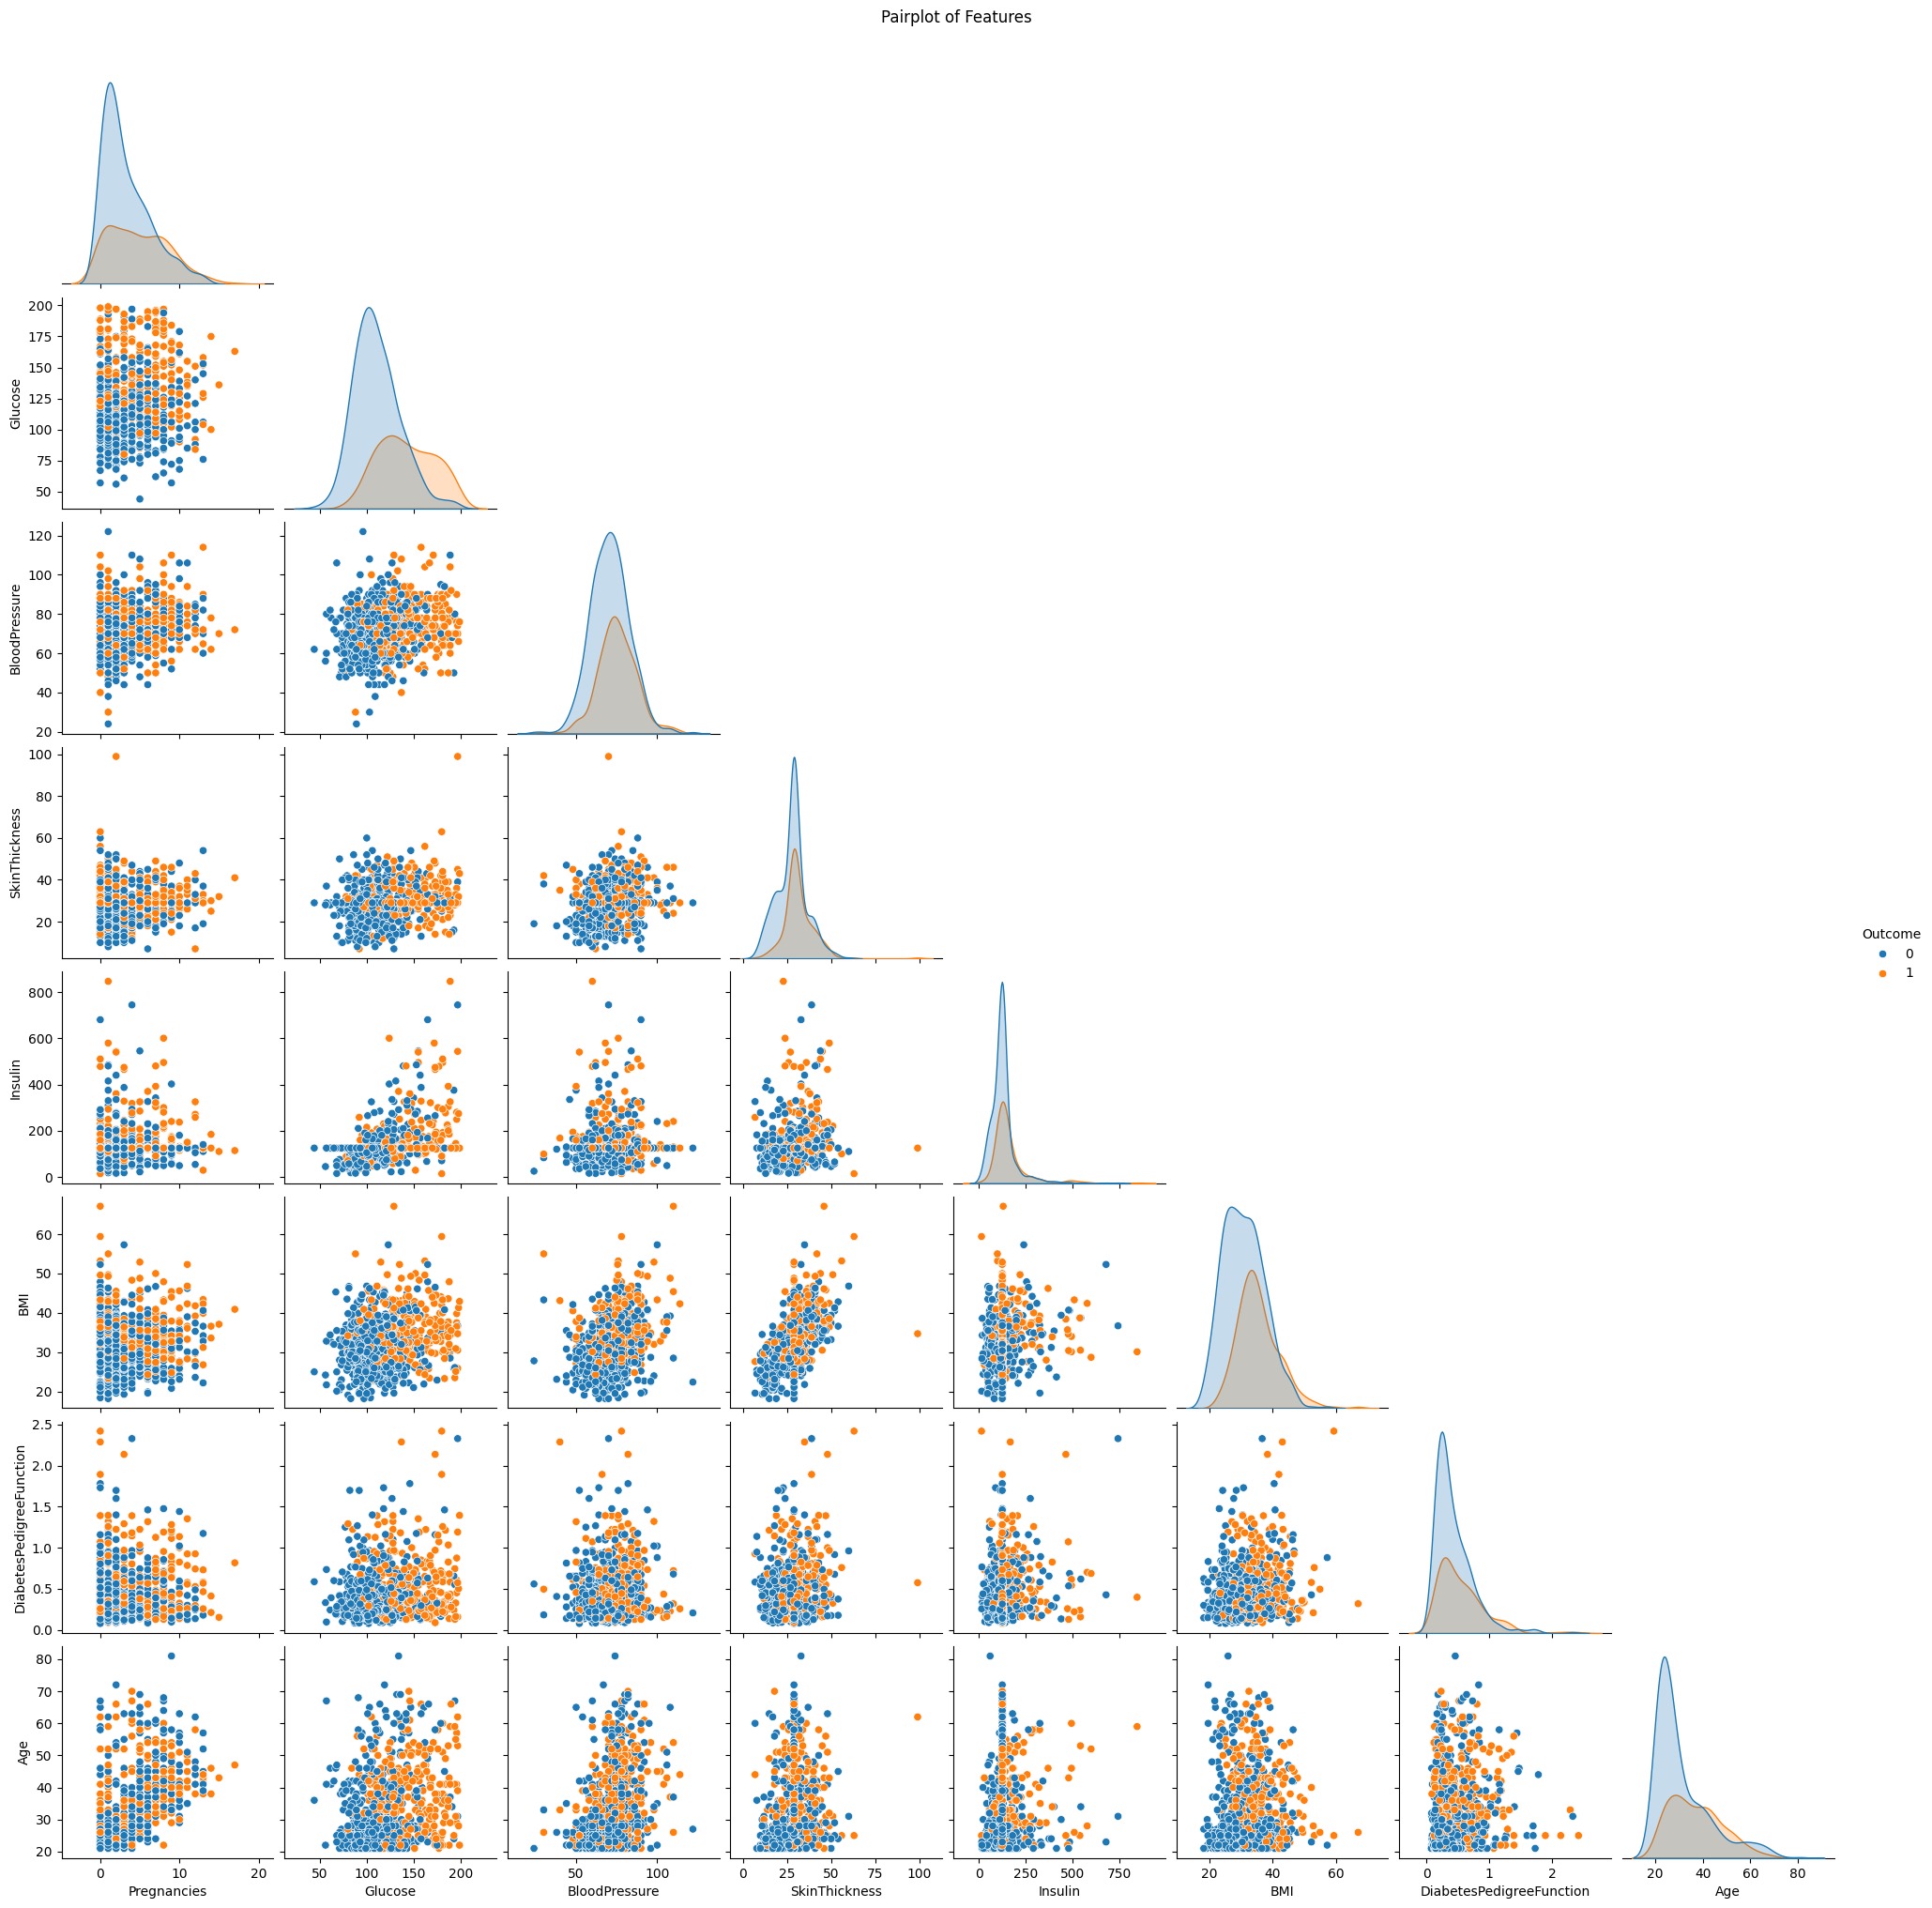

In [ ]:
plt.figure(figsize=(4,4))
sns.pairplot(df,hue="Outcome", diag_kind="kde", corner=True)
plt.suptitle("Pairplot of Features", y=1.02)
plt.show()



*   *Glucose: People with higher glucose levels (orange points) are much more likely to have diabetes. This is the clearest separation.*

*   *BMI: Higher BMI is also linked with diabetes, though not as strongly as glucose.*

*   *Age: Older people are more likely to fall in the diabetes group.*

*   *Pregnancies: More pregnancies slightly increase the chance of diabetes.*

*   *Other features (BloodPressure, SkinThickness, Insulin, PedigreeFunction): These overlap a lot between the two groups, but still might help when used with other features.*








.



### Correlation Heatmap

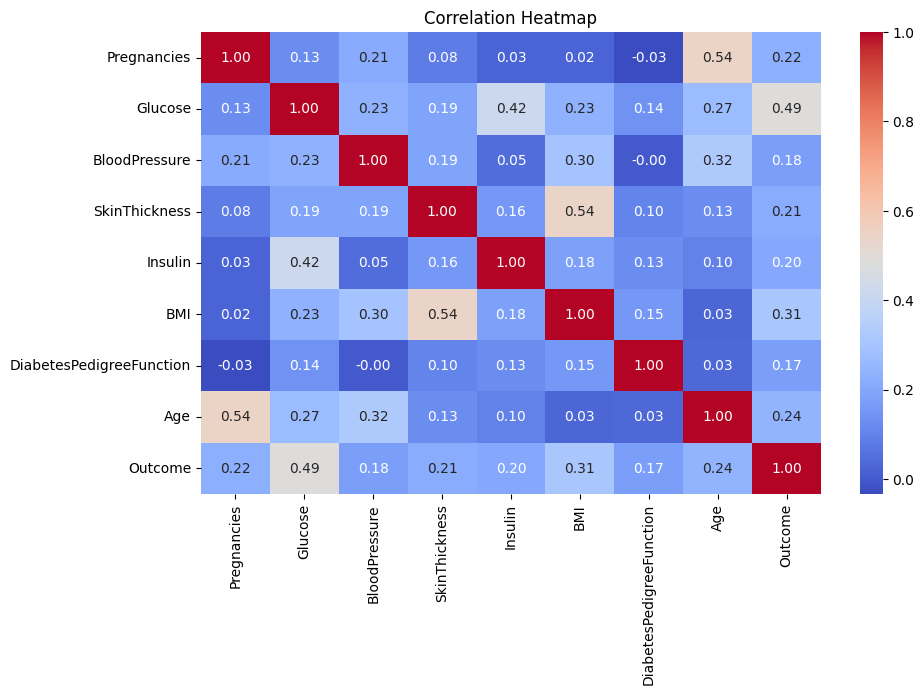

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),annot=True,cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

**The heatmap shows how different features are related to each other and to the diabetes outcome.**

- **Glucose** has the strongest positive correlation with the outcome (0.49), making it the most important predictor.*
- **BMI (0.31)**, **Age (0.24)**, and **Pregnancies (0.22)** also show moderate positive correlation with the outcome.  
- **SkinThickness and BMI (0.54)** are highly correlated, which makes sense since higher BMI is often linked to greater skin thickness.  
- **Glucose and Insulin (0.42)** also show a moderate relationship.  

Overall, **Glucose, BMI, Age, and Pregnancies** are the key features most related to diabetes in this dataset.

### ML Models Building

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.694805   0.574468  0.500000  0.534653  0.650000
1  K-Nearest Neighbors  0.746753   0.666667  0.555556  0.606061  0.702778
2        Random Forest  0.753247   0.673913  0.574074  0.620000  0.712037
3    Gradient Boosting  0.753247   0.673913  0.574074  0.620000  0.712037
4              XGBoost  0.759740   0.673469  0.611111  0.640777  0.725556
5             LightGBM  0.772727   0.702128  0.611111  0.653465  0.735

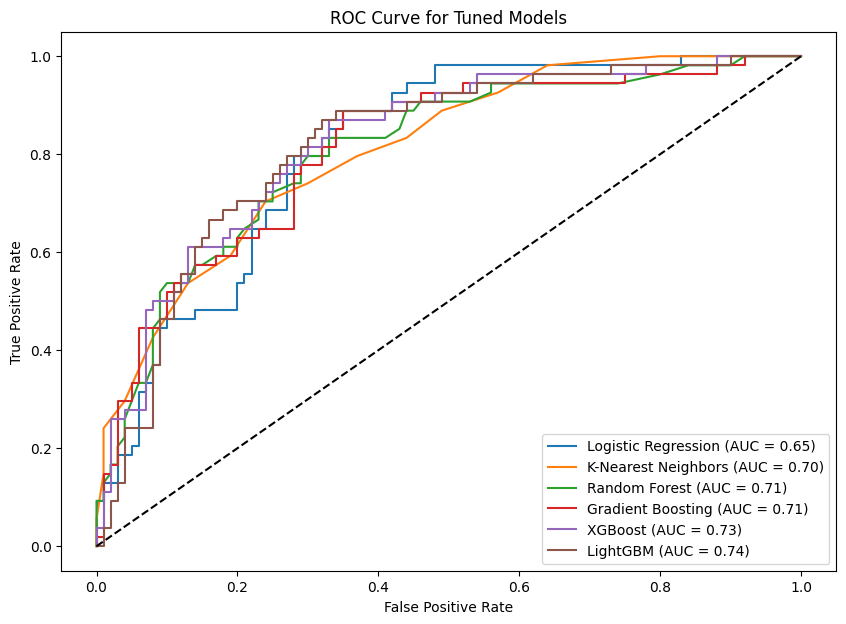

In [ ]:
import warnings
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score, roc_curve, auc

warnings.filterwarnings("ignore")

X=df.drop("Outcome",axis=1)
y=df["Outcome"]

# Train-Test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# Scale data for models that need it
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

# models to try
models={
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# Hyperparameter Grids

param_distributions = {
    "Logistic Regression": {"C":np.logspace(-3,3,7), "penalty":["l2"]},
    "K-Nearest Neighbors": {"n_neighbors": range(3,20), "weights":["uniform","distance"]},
    "Random Forest": {"n_estimators": [100, 200, 500], "max_depth": [3,5,10,None]},
    "Gradient Boosting": {"n_estimators": [100, 200, 500], "learning_rate": [0.01, 0.05, 0.1], "max_depth":[3,5,7]},
    "XGBoost": {"n_estimators": [100, 200, 500], "learning_rate": [0.01, 0.05, 0.1], "max_depth":[3,5,7]},
    "LightGBM": {"n_estimators": [100, 200, 500], "learning_rate": [0.01, 0.05], "num_leaves":[5,10,15], "max_depth":[3,5]}
}

# Train, Tune, Evaluate
results = []
roc_curves = {}

for name, model in models.items():
    # Use scaled data only for Logistic Regression and KNN
    X_train_use = X_train_scaled if name in ["Logistic Regression", "K-Nearest Neighbors"] else X_train
    X_test_use = X_test_scaled if name in ["Logistic Regression", "K-Nearest Neighbors"] else X_test


    # RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions[name], n_iter=10, cv=5, scoring='f1', n_jobs=-1, random_state=42)
    random_search.fit(X_train_use, y_train)

    # Get the best model
    best_model = random_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test_use)
    y_prob = best_model.predict_proba(X_test_use)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    results.append([name, acc, prec, rec, f1, roc_auc])

    # Store ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curves[name] = (fpr, tpr, roc_auc)

# Results Table
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])
print(results_df)

#Plot ROC Curves

plt.figure(figsize=(10,7))

for name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], "k--") # random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Tuned Models")
plt.legend(loc="lower right")
plt.show()

### Model Performance Summary (ROC Curve & Metrics)

- **Logistic Regression**: Lowest performance (AUC = 0.65).  
- **KNN**: Moderate results (AUC = 0.70).  
- **Random Forest**: Solid performer (AUC = 0.71).  
- **Gradient Boosting**: Similar to Random Forest (AUC = 0.71).  
- **XGBoost**: Strong model (AUC = 0.73).  
- **LightGBM**: Best overall (AUC = 0.74).  

**Key Points:**  
- ROC AUC shows how well models separate positive vs negative classes.  
- Curves above the diagonal line mean the model performs better than random guessing.  
- Tree-based ensemble models (LightGBM, XGBoost, RF, GBM) outperform simpler models.  
- **LightGBM is the best choice for this dataset.**